In [620]:
#Okie so I decided to make a new notebook to make this cleaner

In [621]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import joblib

In [622]:
#Lets try to make a new analysis now that we have the day of the week

In [623]:
store_data = pd.read_csv("store_data_final_final.csv")
store_data.head()

,Visitantes,Dia,Mes,Ano,Day of the week,COVID,Season,Event,Total Turistas
0,145,14,12,2018,Friday,0,Autumn,1,15657.580645
1,144,15,12,2018,Saturday,0,Autumn,1,15657.580645
2,131,17,12,2018,Monday,0,Autumn,1,15657.580645
3,355,18,12,2018,Tuesday,0,Autumn,1,15657.580645
4,1267,20,12,2018,Thursday,0,Autumn,1,15657.580645


In [624]:
store_data.dtypes

Visitantes           int64
Dia                  int64
Mes                  int64
Ano                  int64
Day of the week     object
COVID                int64
Season              object
Event                int64
Total Turistas     float64
dtype: object

In [625]:
#now we create a new variable to store our df
#we gonna convert the column day of the week changing the day name to number to help with further analysis

In [626]:
store = store_data

In [627]:
def week_day_to_num(df):
    if df["Day of the week"] == "Sunday":
        return 1
    if df["Day of the week"] == "Monday":
        return 2
    if df["Day of the week"] == "Tuesday":
        return 3
    if df["Day of the week"] == "Wednesday":
        return 4
    if df["Day of the week"] == "Thursday":
        return 5
    if df["Day of the week"] == "Friday":
        return 6
    if df["Day of the week"] == "Saturday":
        return 7

In [628]:
store.head()

,Visitantes,Dia,Mes,Ano,Day of the week,COVID,Season,Event,Total Turistas
0,145,14,12,2018,Friday,0,Autumn,1,15657.580645
1,144,15,12,2018,Saturday,0,Autumn,1,15657.580645
2,131,17,12,2018,Monday,0,Autumn,1,15657.580645
3,355,18,12,2018,Tuesday,0,Autumn,1,15657.580645
4,1267,20,12,2018,Thursday,0,Autumn,1,15657.580645


In [629]:
store["Week day"] = store.apply(week_day_to_num,axis=1)
store.head()

,Visitantes,Dia,Mes,Ano,Day of the week,COVID,Season,Event,Total Turistas,Week day
0,145,14,12,2018,Friday,0,Autumn,1,15657.580645,6
1,144,15,12,2018,Saturday,0,Autumn,1,15657.580645,7
2,131,17,12,2018,Monday,0,Autumn,1,15657.580645,2
3,355,18,12,2018,Tuesday,0,Autumn,1,15657.580645,3
4,1267,20,12,2018,Thursday,0,Autumn,1,15657.580645,5


In [630]:
store = pd.get_dummies(store,columns=["Season"])
store.head()

,Visitantes,Dia,Mes,Ano,Day of the week,COVID,Event,Total Turistas,Week day,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,145,14,12,2018,Friday,0,1,15657.580645,6,1,0,0,0
1,144,15,12,2018,Saturday,0,1,15657.580645,7,1,0,0,0
2,131,17,12,2018,Monday,0,1,15657.580645,2,1,0,0,0
3,355,18,12,2018,Tuesday,0,1,15657.580645,3,1,0,0,0
4,1267,20,12,2018,Thursday,0,1,15657.580645,5,1,0,0,0


C:\Users\betti\AppData\Local\Temp\ipykernel_13172\3900052727.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


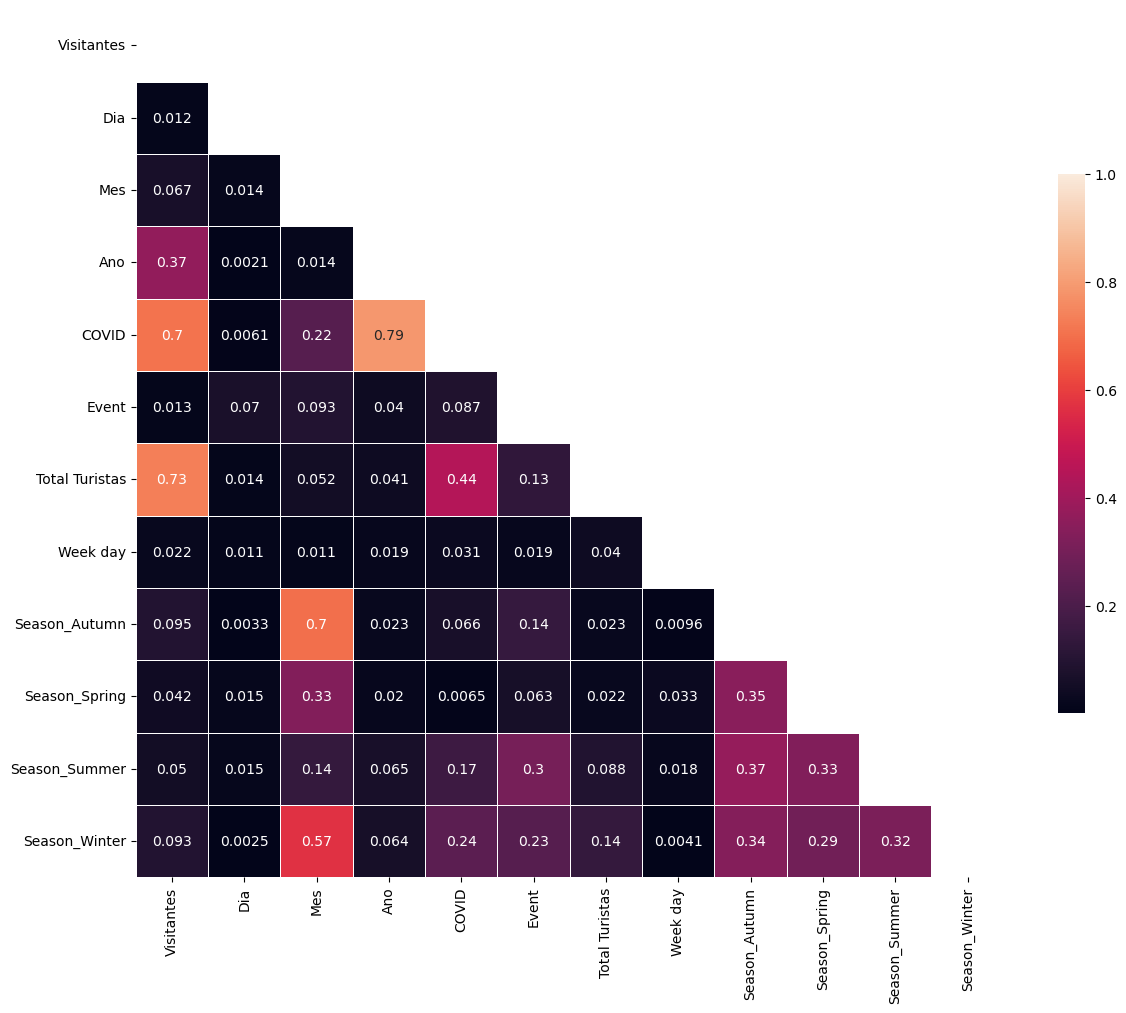

In [631]:
#Time for visuals

corr=np.abs(store.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(14, 14))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

In [632]:
#Now that we got our heatmap, we gotta fix our data types before we start analyzing
#we need to do that so when training the algorithm, our pc doesnt think day 4 is double of 2 and etc
store = store.astype({"Ano":str, "Mes": str, "Dia": str,"Week day":str})

#we also drop the year column since it was messing up with our last predictions

store.drop(["Ano","Day of the week"],axis=1,inplace=True)

In [633]:
store.dtypes

Visitantes          int64
Dia                object
Mes                object
COVID               int64
Event               int64
Total Turistas    float64
Week day           object
Season_Autumn       uint8
Season_Spring       uint8
Season_Summer       uint8
Season_Winter       uint8
dtype: object

In [634]:
#Let's find some outliers 

Q1 = store["Visitantes"].quantile(0.25)
Q3 = store["Visitantes"].quantile(0.75)

IQR = Q3-Q1

store = store[~((store_data["Visitantes"] < (Q1 - 1.5 * IQR)) | (store["Visitantes"] > (Q3 + 1.5 * IQR)))]

In [635]:
print(store[store["Visitantes"]<50].count())
print(store[store["Visitantes"]>1500].count())

Visitantes        13
Dia               13
Mes               13
COVID             13
Event             13
Total Turistas    13
Week day          13
Season_Autumn     13
Season_Spring     13
Season_Summer     13
Season_Winter     13
dtype: int64
Visitantes        35
Dia               35
Mes               35
COVID             35
Event             35
Total Turistas    35
Week day          35
Season_Autumn     35
Season_Spring     35
Season_Summer     35
Season_Winter     35
dtype: int64


In [636]:
#Still on outliers but a bit more manual now 
store = store[store["Visitantes"]>10]

store = store[store["Visitantes"]<1000]

In [637]:
#Prediction time, let's see if this got any better

X =  store.drop("Visitantes", axis=1)
y = store["Visitantes"]

#split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [638]:
rf = RandomForestRegressor()

rf.fit(X_train,y_train)

print("Score: ", rf.score(X_test,y_test))

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
error = np.sqrt(mse)

print("Pred error: ", error)

Score:  0.8392983826781765
Pred error:  100.86938944843243


In [639]:
#joblib.dump(rf, 'store_rf_model.joblib') #we saved already

In [640]:
#Let's now do a grid search

# we need to define what we consider the "full list" of hyperparameters
# Number of trees in random forest
n_estimators = [500,700,900,1000]
# Mximum number of total leaves to consider
max_leaf_nodes = [15, 30, 40]
# Maximum number of levels in each tree
max_depth = [5,10]

# Create the  grid
# this is a dictionary from hyperparameters to potential values
# the keys in this dictionary have to match the names of the hyperparameters in the documentation of the model
grid = {'n_estimators': n_estimators,
        'max_leaf_nodes': max_leaf_nodes,
        'max_depth': max_depth}

# Instantiate the grid search model object
# estimator -> model to optimize
forest = RandomForestRegressor()
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = forest, param_grid = grid, cv = 5)

In [641]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 10, 'max_leaf_nodes': 40, 'n_estimators': 700}
Best cross-validation score:  0.8469289786170139


In [647]:
#Now let's use the parameters we found:

rf = RandomForestRegressor(max_depth= 10, max_leaf_nodes= 40, n_estimators= 700)

rf.fit(X_train,y_train)

print("Score: ", rf.score(X_test,y_test))

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
error = np.sqrt(mse)

print("Pred error: ", error)

#joblib.dump(rf, 'store_rf_wparam_model.joblib') #we saved already

Score:  0.8132367108347431
Pred error:  108.7414263354268
